In [ ]:
! wget https://www.dropbox.com/s/4o333d7dl6karyn/PH2Dataset.rar

--2021-05-16 20:07:40--  https://www.dropbox.com/s/4o333d7dl6karyn/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4o333d7dl6karyn/PH2Dataset.rar [following]
--2021-05-16 20:07:40--  https://www.dropbox.com/s/raw/4o333d7dl6karyn/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc03f8791fb246d58f816395ad62.dl.dropboxusercontent.com/cd/0/inline/BOn0d-2qre-2NaEp0NYiUK6ULOFzLtDojQ-z25s6LKpMRGcq5e1l-txkPYus7pwY1CgyFM0ccXSPxo6d-TpO-9juppYVbRenEUmHqZhgaaBDI3jrD0BBEwnhqU92x5mVMQpo4c7NupozCAxeHinjoXq-/file# [following]
--2021-05-16 20:07:40--  https://uc03f8791fb246d58f816395ad62.dl.dropboxusercontent.com/cd/0/inline/BOn0d-2qre-2NaEp0NYiUK6ULOFzLtDojQ-z25s6LKpMRGcq5e1l-txkPYus7pwY1CgyFM0ccXSPxo6d-

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
import tensorflow as tf

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(2, 2, return_indices=True)
 
        # bottleneck За основу взята сеть vvg-16, в которо 512 сворачивается в 512 
        self.bottleneck_conv = nn.Sequential( nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1))
 
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.SiLU()
        )
 
    def forward(self, x)

        e0, in0 = self.pool0(self.enc_conv0(x))
        e1, in1 = self.pool1(self.enc_conv1(e0))
        e2, in2 = self.pool2(self.enc_conv2(e1))
        e3, in3 = self.pool3(self.enc_conv3(e2))
 
       
        b = self.bottleneck_conv(e3)

 
 
        d0 = self.dec_conv0(self.upsample0(b, in3))
        d1 = self.dec_conv1(self.upsample1(d0, in2))
        d2 = self.dec_conv2(self.upsample2(d1, in1))
        d3 = self.dec_conv3(self.upsample3(d2, in0))
        return d3

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))        
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() 
    return thresholded  

In [ ]:
def bce_loss(y_real, y_pred):
  y_real = y_real.view(-1)
  y_pred = y_pred.view(-1)
  l = torch.clamp(y_pred, min = 0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))
  return l.mean()

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train() 
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            X_val = X_val.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()  

            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        model.eval()  
        Y_hat = model(X_val).detach().cpu()
        X_val = X_val.to('cpu')
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
      with torch.no_grad():
        Y_pred = torch.round(torch.sigmoid(model(X_batch.to(device))))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
model = SegNet().to(device)

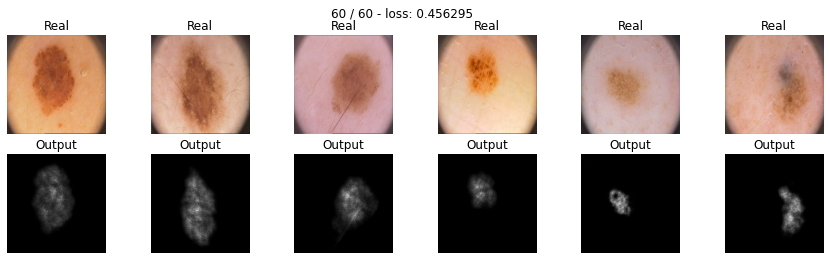

In [ ]:
max_epochs = 60
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-08);
history = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.5620000064373016

In [ ]:
def dice_loss2(y_real, y_pred):
    y_pred = torch.clamp(y_pred.sigmoid(), min=1e-6, max = 1-(1e-6)).view(-1)
    y_real = y_real.view(-1)    
    num = 2*(y_real * y_pred).sum()
    den =  (y_real + y_pred + 1e-6).sum()
    res = num/den
    res1 = 1 - res 
    return res1

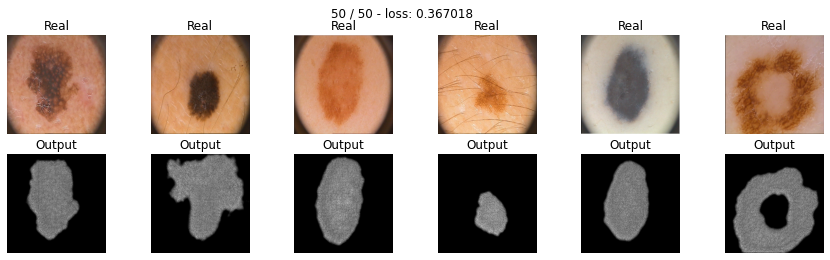

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 50
optimaizer =  torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss2, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.6559999883174896

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
  y_pred = torch.clamp(y_pred, eps, 1. - eps)
  your_loss = -(((1-torch.sigmoid(y_pred))**gamma) * y_real * torch.log(torch.sigmoid(y_pred)) + (1-y_real) * torch.log (1 - torch.sigmoid(y_pred))).mean()
  return your_loss


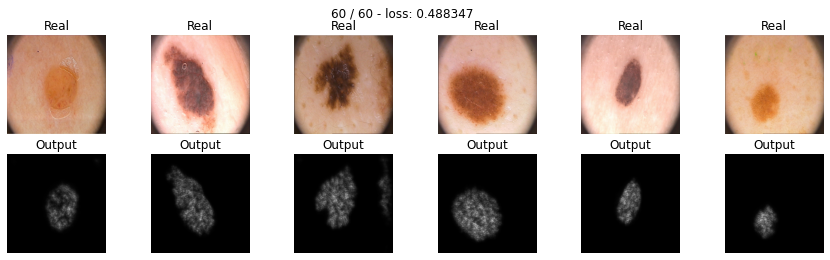

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 60
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.5840000212192535

In [ ]:
def tver_loss(targets, inputs):
        inputs = torch.sigmoid(inputs)
        true_pres = (inputs * targets).sum() 
        false_pres = ((1-targets) * inputs).sum()
        false_neg = (targets * (1-inputs)).sum()
       
        tv = (true_pres + 1) / (true_pres + 0.5*false_pres + 0.5*false_neg + 1)  
        
        return 1-tv

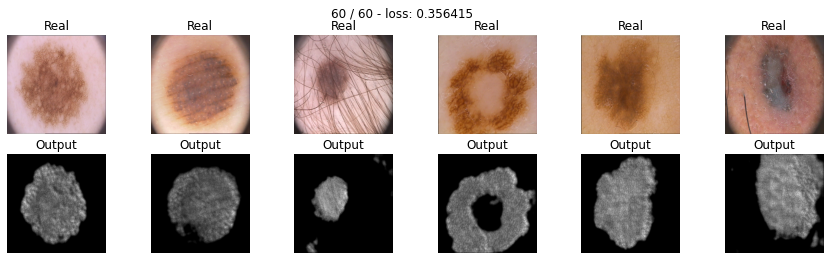

In [ ]:
max_epochs = 60
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-08);
history = train(model, optim, tver_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.742000013589859

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(2, 2, return_indices=True)
 

        self.bottleneck_conv = nn.Sequential( nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1))

        self.upsample0 = nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.SiLU()
        )
 
    def forward(self, x):

        e0_p = self.enc_conv0(x)
        e0, in0 = self.pool0(e0_p)
        #print('e0')
        #print(e0.shape)
        #print('e0_p')
        #print(e0_p.shape)
        e1_p = self.enc_conv1(e0)
        e1, in1 = self.pool1(e1_p)
        #print('e1')
        #print(e1.shape)
        #print('e1_p')
        #print(e1_p.shape)
        e2_p = self.enc_conv2(e1)
        e2, in2 = self.pool2(e2_p)
        #print('e2')
        #print(e2.shape)
        #print('e2_p')
        #print(e2_p.shape)
        e3_p = self.enc_conv3(e2)
        e3, in3 = self.pool3(e3_p)
        #print('e3')
        #print(e3.shape)
        #print('e3_p')
        #print(e3_p.shape)
        # bottleneck
        b = self.bottleneck_conv(e3)
        #print('b')
        #print(b.shape)
 
 
        d0 = self.upsample0(b, in3)
        #print('d0')
        #print(d0.shape)
        d0 = torch.cat((e3_p, d0), 1)
        #print('d0')
        #print(d0.shape)
        d0 = self.dec_conv0(d0)
        #print('d0')
        #print(d0.shape)
        d1 = self.upsample1(d0, in2)
        d1 = torch.cat((e2_p, d1), 1)
        d1 = self.dec_conv1(d1)
        #print('d1')
        #print(d1.shape)
        d2 = self.upsample2(d1, in1)
        d2 = torch.cat((e1_p, d2), 1)
        d2 = self.dec_conv2(d2)
        #print('d2')
        #print(d2.shape)
        d3 = self.upsample3(d2, in0)
        d3 = torch.cat((e0_p, d3), 1)
        d3 = self.dec_conv3(d3)
        #print('d3')
        #print(d3.shape)
        return d3

In [ ]:
unet_model = UNet().to(device)

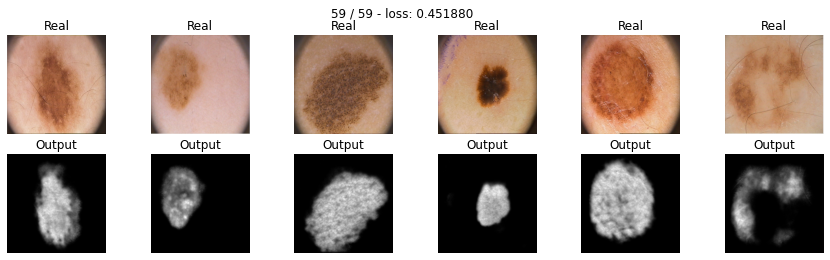

In [ ]:
train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 59, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.714000016450882

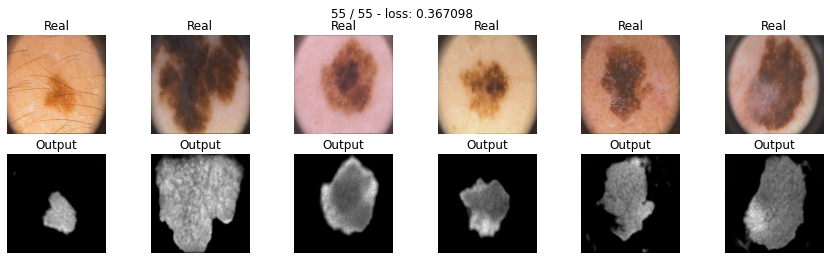

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), dice_loss2, 55, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7059999704360962

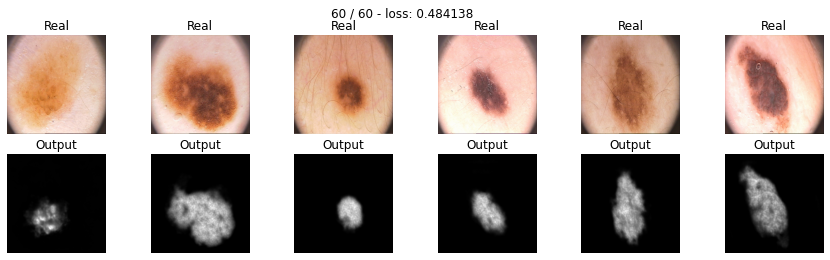

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), focal_loss, 60, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6580000221729279

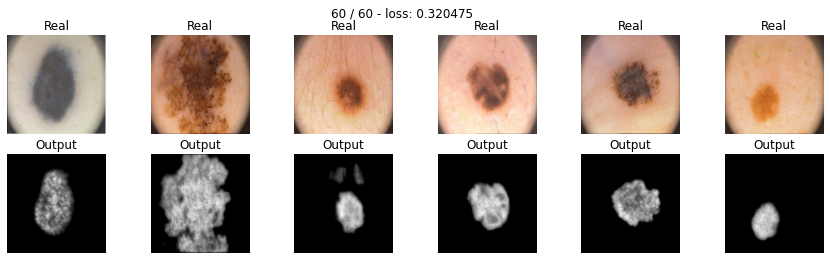

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), tver_loss, 60, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7160000205039978

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
 
  
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU())
 

        self.bottleneck_conv = nn.Sequential( nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1))

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.SiLU()
        )
 
    def forward(self, x):

        e0_p = self.enc_conv0(x)
        e0 = self.pool0(e0_p)
        #print('e0')
        #print(e0.shape)
        #print('e0_p')
        #print(e0_p.shape)
        e1_p = self.enc_conv1(e0)
        e1 = self.pool1(e1_p)
        #print('e1')
        #print(e1.shape)
        #print('e1_p')
        #print(e1_p.shape)
        e2_p = self.enc_conv2(e1)
        e2 = self.pool2(e2_p)
        #print('e2')
        #print(e2.shape)
        #print('e2_p')
        #print(e2_p.shape)
        e3_p = self.enc_conv3(e2)
        e3 = self.pool3(e3_p)
        #print('e3')
        #print(e3.shape)
        #print('e3_p')
        #print(e3_p.shape)
        b = self.bottleneck_conv(e3)
        #print('b')
        #print(b.shape)
 
 
        d0 = self.upsample0(b)
        #print('d0')
        #print(d0.shape)
        d0 = torch.cat((e3_p, d0), 1)
        #print('d0')
        #print(d0.shape)
        d0 = self.dec_conv0(d0)
        #print('d0')
        #print(d0.shape)
        d1 = self.upsample1(d0)
        #print('d1')
        #print(d1.shape)
        d1 = torch.cat((e2_p, d1), 1)
        #print('d1')
        #print(d1.shape)
        d1 = self.dec_conv1(d1)
        #print('d1')
        #print(d1.shape)
        d2 = self.upsample2(d1)
        #print('d2')
        #print(d2.shape)
        d2 = torch.cat((e1_p, d2), 1)
        #print('d2')
        #print(d2.shape)
        d2 = self.dec_conv2(d2)
        #print('d2')
        #print(d2.shape)
        d3 = self.upsample3(d2)
        #print('d3')
        #print(d3.shape)
        d3 = torch.cat((e0_p, d3), 1)
        #print('d3')
        #print(d3.shape)
        d3 = self.dec_conv3(d3)
        #print('d3')
        #print(d3.shape)
        return d3



In [ ]:
unet2_model = UNet2().to(device)


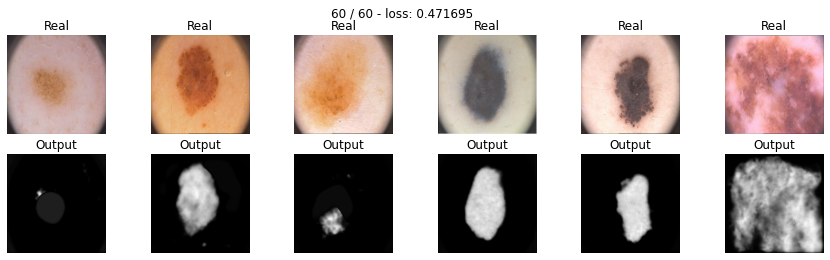

In [ ]:
train(unet2_model, torch.optim.Adam(unet2_model.parameters()), bce_loss, 60, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.5940000116825104

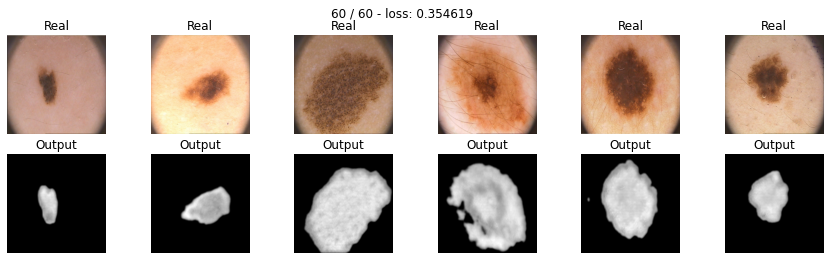

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), dice_loss2, 60, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.6539999842643738

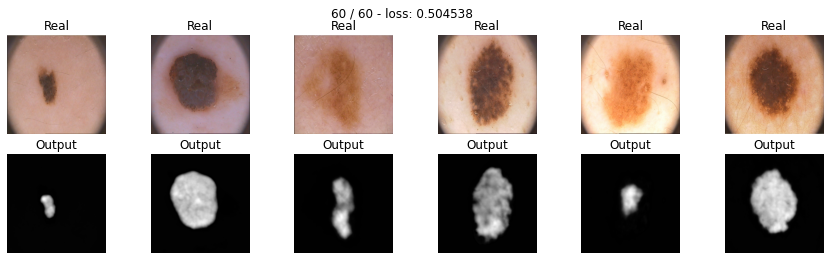

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), focal_loss, 60, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.6439999938011169

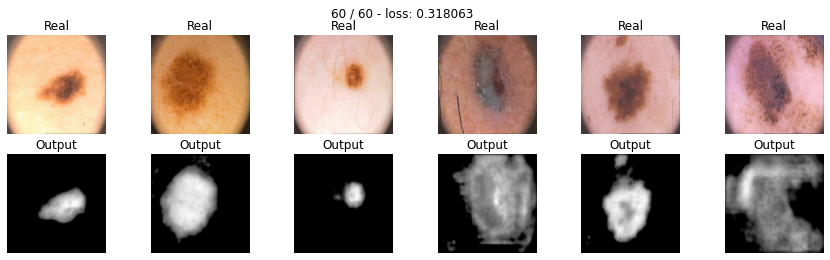

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), tver_loss, 60, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.6780000329017639

**НАЧЕРТИМ ДИАГРАММЫ:**

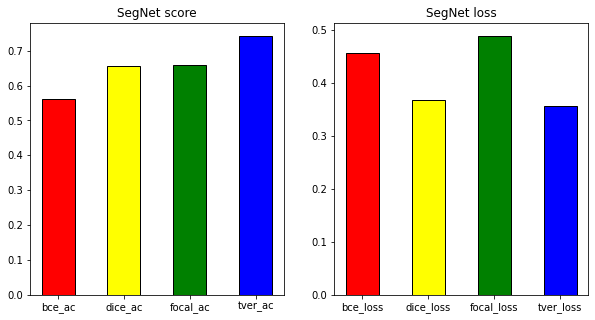

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
ax1.set_title('SegNet score')
ax2.set_title('SegNet loss')
index = ['bce_ac','dice_ac','focal_ac','tver_ac']
values = [0.5620000064373016, 0.6559999883174896, 0.6580000221729279,0.742000013589859]
colors = ["red", "yellow", "green", "blue"]
w = [0.5, 0.5, 0.5, 0.5]
ax1.bar(index,values,color = colors, width=w, edgecolor = 'black')
index = ['bce_loss','dice_loss','focal_loss','tver_loss']
values = [0.456295, 0.367018, 0.488347,0.356415]
colors = ["red", "yellow", "green", "blue"]
w = [0.5, 0.5, 0.5, 0.5]
ax2.bar(index,values,color = colors, width=w, edgecolor = 'black')
plt.show()


Как можно увидеть по графику, лидирует функция потерь - Тверский лосс

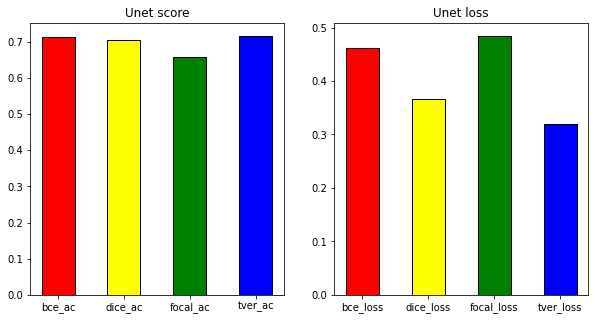

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
ax1.set_title('Unet score')
ax2.set_title('Unet loss')
index = ['bce_ac','dice_ac','focal_ac','tver_ac']
values = [0.714000016450882, 0.7059999704360962, 0.6580000221729279,0.7160000205039978]
colors = ["red", "yellow", "green", "blue"]
w = [0.5, 0.5, 0.5, 0.5]
ax1.bar(index,values,color = colors, width=w, edgecolor = 'black')
index = ['bce_loss','dice_loss','focal_loss','tver_loss']
values = [0.461880, 0.367018, 0.4841128,0.320475]
colors = ["red", "yellow", "green", "blue"]
w = [0.5, 0.5, 0.5, 0.5]
ax2.bar(index,values,color = colors, width=w, edgecolor = 'black')
plt.show()

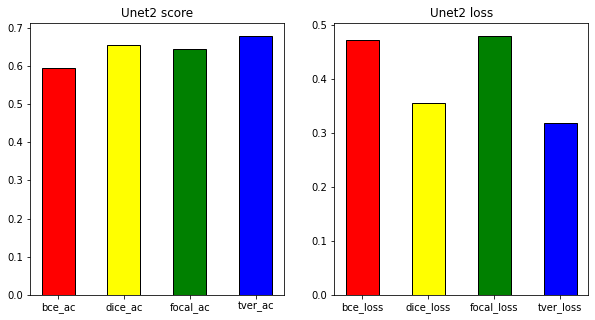

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
ax1.set_title('Unet2 score')
ax2.set_title('Unet2 loss')
index = ['bce_ac','dice_ac','focal_ac','tver_ac']
values = [0.5940000116825104, 0.6539999842643738, 0.6439999938011169,0.6780000329017639]
colors = ["red", "yellow", "green", "blue"]
w = [0.5, 0.5, 0.5, 0.5]
ax1.bar(index,values,color = colors, width=w, edgecolor = 'black')
index = ['bce_loss','dice_loss','focal_loss','tver_loss']
values = [0.471695, 0.354619,0.479010,0.318063]
colors = ["red", "yellow", "green", "blue"]
w = [0.5, 0.5, 0.5, 0.5]
ax2.bar(index,values,color = colors, width=w, edgecolor = 'black')
plt.show()

**НАЧЕРТИМ ИТОГОВУЮ ТАБЛИЦУ**

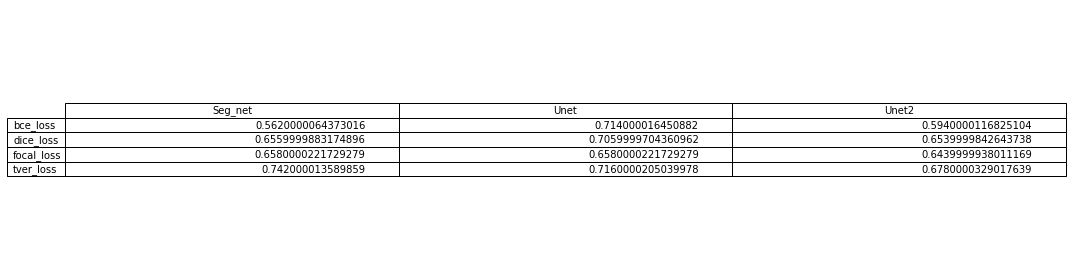

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame([[0.5620000064373016,0.714000016450882,0.5940000116825104],[ 0.6559999883174896,0.7059999704360962,0.6539999842643738],
                   [0.6580000221729279,0.6580000221729279,0.6439999938011169],
                   [0.742000013589859,0.7160000205039978,0.6780000329017639]], index = ['bce_loss','dice_loss','focal_loss','tver_loss'], columns=['Seg_net','Unet','Unet2'])

ax.table(cellText=df.values, rowLabels= df.index, colLabels=df.columns, loc='center')

fig.tight_layout()

plt.show()

**Наблюдения и выводы, которые я для себя сделала:**

 Как можно увидеть **Тверский loss** показывает наилучший результат для всех моделей, более того на **SegNet** с tver loss модель выдает наилучший результат, прочитав статью, я сделала для себя вывод. По моему мнению, это происходит, потому что **Unet** преднозначена для сегментирования более мелких изображений, например для сегментации клеток, у нас не такой мелкий масштаб.
 Однако стальные же функции потерь(помимо tver loss) дают лучший результат на сети Unet.

В Unet так же хорошо себя показывает **Dice**, более того в статье говорится, что эта функция потерь является наиболее часто используемой потерей при проблемах сегментации, поэтому хорший результат оправдывает ожидания.(Что логично, иначе бы этот loss не был бы таким популярным).

Не смотря на то, что **BCE** является стандартной функцией потерь для бинарной классификации, как видно по графикам, на моих моделях эта функция потерь дает не самый лучший результат

**ИТОГ:**
Как было сказано ранее лучшую точность имеет SegNet на TverLoss, однака в среднем на всех фунциях потерь лучшую точность дает UNet(1), худшую точность из всех модель показывает UNet2.